In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import pygame
import tensorflow as tf

from IPython.display import clear_output

from agents import Agent, HumanAgent, RLAgent
from game import Game

has_gpu = tf.test.is_gpu_available()
# Primeira chamada do keras produz muitos logs, então chamamos aqui para limpar
tf.keras.Model()
# Limpa texto desnecessário
clear_output()

if not has_gpu:
    print("Nenhuma GPU dedicada detectada. O treinamento do modelo pode ser muito demorado.")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Espaço de observações: Box(0, 255, (210, 160), uint8)
Espaço de ações: Discrete(6)


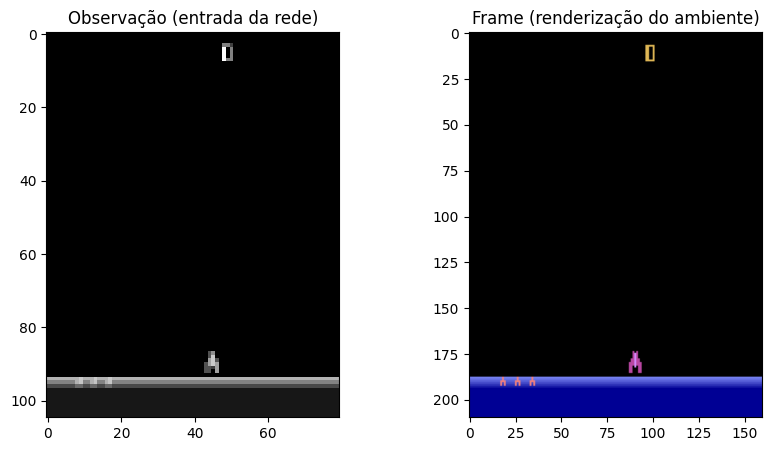

In [2]:
env = gym.make("DemonAttackNoFrameskip-v4", obs_type="grayscale", render_mode="rgb_array")
# Não muda nada, mas evita warnings
env.metadata["render_fps"] = 60
env.reset()
observation, _, _, _, _ = env.step(0)
observation = tf.image.resize(observation[:, :, None], (105, 80))
frame = env.render()

print("Espaço de observações:", env.observation_space)
print("Espaço de ações:", env.action_space)
n_actions = env.action_space.n
env.close()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(observation, cmap="gray")
ax[0].title.set_text("Observação (entrada da rede)")
ax[1].imshow(frame)
ax[1].title.set_text("Frame (renderização do ambiente)")
plt.show()

Ações:

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>Value</p></th>
<th class="head"><p>Meaning</p></th>
<th class="head"><p>Value</p></th>
<th class="head"><p>Meaning</p></th>
<th class="head"><p>Value</p></th>
<th class="head"><p>Meaning</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">0</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">NOOP</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">1</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">FIRE</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">2</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">RIGHT</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">3</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">LEFT</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">4</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">RIGHTFIRE</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">5</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">LEFTFIRE</span></code></p></td>
</tr>
</tbody>
</table>

In [3]:
mapping = {
    (pygame.K_a, pygame.K_d, pygame.K_SPACE): 1,    # Atirar
    (pygame.K_d, pygame.K_SPACE): 4,                # Direita e atirar
    (pygame.K_a, pygame.K_SPACE): 5,                # Esquerda e atirar
    (pygame.K_a, pygame.K_d): 0,                    # Ficar parado
    pygame.K_SPACE: 1,                              # Atirar
    pygame.K_d: 2,                                  # Direita
    pygame.K_a: 3                                   # Esquerda
}

In [4]:
# ALE/DemonAttack-v5 skips 4 frames
game = Game(
    "DemonAttackNoFrameskip-v4",
    # RLAgent(n_actions, (105, 80)),
    Agent(n_actions),
    rotated=True,
    human_agent=HumanAgent(mapping)
)

In [5]:
game.play(human_player=False)

In [ ]:
# game.train(render=True)

In [ ]:
game.close()